In [45]:
!pip install pyriemann
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold

## Step 1 : Dataset preparation and augmentation through overlapping window

### Handling of the guided gestures training/validation data

#### Guided training/validation data loading, shape and size checking

In [46]:
# Data loading
X_guided=np.load(r"C:\Users\pavel\OneDrive\Documents\BIG DATA 2024-2025\Session2\Statistical foundations of machine learning\project\F422 EMG project data\guided\guided_dataset_X.npy")

# Shape and size checking
print(X_guided.shape, np.size(X_guided))

(5, 8, 230000) 9200000


The dataset shows the records of 5 sessions, 8 electrodes for 230 0000 points of time. The dataset contains then 9 200 000 records.

#### Guided training/validation data augmentation, shape and size checking

In [47]:
# Data segmentation, window size = 500, overlap=75%
X_guided_augmented=sliding_window_view(X_guided, 500,axis=2)[:,:, ::125]

# Shape and size checking
print(X_guided_augmented.shape,np.size(X_guided_augmented))

(5, 8, 1837, 500) 36740000


The augmented dataset shows the records of 5 sessions, 8 electrodes and 18737 intervals of time (with an overlap of 75%). Each interval of time contains records for 500 points of time. The dataset contains now 36 740 000 records.

In [48]:
# Ratio of augmented data size to original data
print(np.size(X_guided_augmented)/np.size(X_guided))

3.993478260869565


The augmented dataset has a size of about 4 times with respect to the original dataset.

### Handling of the guided gestures training/validation target (hand pose estimation) data

#### Guided training/validation target data  loading, shape and size checking

In [49]:
# Data loading
Y_guided=np.load(r"C:\Users\pavel\OneDrive\Documents\BIG DATA 2024-2025\Session2\Statistical foundations of machine learning\project\F422 EMG project data\guided\guided_dataset_y.npy")

In [50]:
# Shape and size checking
print(Y_guided.shape, np.size(Y_guided))

(5, 51, 230000) 58650000


The dataset shows the records of 51 joint-angles for 5 sessions (5 predefined hand postures) and 230 0000 points of time. The dataset contains then 58 650 000 records.

#### Guided training/validation target data segmentation, keeping of the up bound point of time of each window

In [51]:
# Data segmentation, window size = 500, overlap=75%
Y_guided_slided=sliding_window_view(Y_guided, 500,axis=2)[:,:, ::125]
# Shape checking
print(Y_guided_slided.shape)

(5, 51, 1837, 500)


In [52]:
# Reducing each window to the up bound point of time
Y_guided_slided=Y_guided_slided[:,:,:,-1:]

In [53]:
# Shape checking
print(Y_guided_slided.shape)

(5, 51, 1837, 1)


### Handling of the free gestures training/validation data

#### Free moves training/validation data loading, shape and size checking

In [54]:
# Data loading
X_freemoves=np.load(r"C:\Users\pavel\OneDrive\Documents\BIG DATA 2024-2025\Session2\Statistical foundations of machine learning\project\F422 EMG project data\freemoves\freemoves_dataset_X.npy")

# Shape and size checking
print(X_freemoves.shape, np.size(X_freemoves))

(5, 8, 270000) 10800000


The dataset shows the records of 5 sessions, 8 electrodes for 270 0000 points of time. The dataset contains then 10 800 000 records.

#### Free moves training/validation data augmentation, shape and size checking

In [55]:
# Data segmentation, window size = 500, overlap=75%
X_freemoves_augmented=sliding_window_view(X_freemoves, 500,axis=2)[:,:, ::125]

# Shape and size checking
print(X_freemoves_augmented.shape,np.size(X_freemoves_augmented))

(5, 8, 2157, 500) 43140000


The augmented dataset shows the records of 5 sessions, 8 electrodes and 2157 intervals of time (with an overlap of 75%). Each interval of time contains records for 500 points of time, resulting then in a number of 43 140 000 records for the dataset.

In [56]:
# Ratio of augmented data size to original data
print(np.size(X_freemoves_augmented)/np.size(X_freemoves))

3.9944444444444445


The augmented dataset has a size of about 4 times with respect to the original dataset.

### Handling of the free gestures training/validation target (hand pose estimation) data

#### Free moves training/validation target data  loading, shape and size checking

In [57]:
# Data loading
Y_freemoves=np.load(r"C:\Users\pavel\OneDrive\Documents\BIG DATA 2024-2025\Session2\Statistical foundations of machine learning\project\F422 EMG project data\freemoves\freemoves_dataset_y.npy")

In [58]:
# Shape and size checking
print(Y_freemoves.shape, np.size(Y_freemoves))

(5, 51, 270000) 68850000


The dataset shows the records of 51 joint-angles for 5 sessions (5 predefined hand postures) and 270 0000 points of time. The dataset contains then 68 850 000 records.

#### Free moves training/validation target data segmentation, keeping of the up bound point of time of each window

In [59]:
# Data segmentation, window size = 500, overlap=75%
Y_freemoves_slided=sliding_window_view(Y_freemoves, 500,axis=2)[:,:, ::125]
# Shape checking
print(Y_freemoves_slided.shape)

(5, 51, 2157, 500)


In [60]:
# Reducing each window to the up bound point of time
Y_freemoves_slided=Y_freemoves_slided[:,:,:,-1:]

In [61]:
# Shape checking
print(Y_freemoves_slided.shape)

(5, 51, 2157, 1)


# 2) Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation

 Step 1 — Window extraction with session labels

In [62]:
def create_overlapping_windows(X, y, window_size=500, overlap=0.75):
    """
    Segments raw sEMG and joint-angle signals into overlapping windows.
    Also records the session index for each window.

    Parameters:
        X (np.ndarray): shape (num_sessions, num_electrodes, num_timesteps)
        y (np.ndarray): shape (num_sessions, num_joints, num_timesteps)
        window_size (int): number of time points per window (default = 500)
        overlap (float): fraction of overlap between consecutive windows (e.g. 0.75 for 75%)

    Returns:
        X_windows (np.ndarray): shape (n_windows, num_electrodes, window_size)
        y_windows (np.ndarray): shape (n_windows, num_joints, window_size)
        session_labels (np.ndarray): shape (n_windows,), session index for each window
    """
    step_size = int(window_size * (1 - overlap))  # Distance between window starts
    X_windows, y_windows, session_labels = [], [], []

    for session_idx in range(X.shape[0]):
        emg = X[session_idx]     # shape (8, T)
        joints = y[session_idx]  # shape (51, T)
        T = emg.shape[1]

        # Slide window over time axis
        for start in range(0, T - window_size + 1, step_size):
            end = start + window_size
            X_windows.append(emg[:, start:end])        # Extract EMG window
            y_windows.append(joints[:, start:end])     # Extract joint-angle window
            session_labels.append(session_idx)         # Label the window by session

    return np.array(X_windows), np.array(y_windows), np.array(session_labels)


Step 2 -  Leave-One-Session-Out Cross-Validation

In [63]:
def leave_one_session_out_cv(X_windows, y_windows, session_labels):
    """
    Yields train/validation splits for Leave-One-Session-Out cross-validation.

    Parameters:
        X_windows (np.ndarray): EMG data windows
        y_windows (np.ndarray): joint-angle windows
        session_labels (np.ndarray): session index for each window

    Yields:
        X_train, X_val, y_train, y_val (each np.ndarray)
    """
    unique_sessions = np.unique(session_labels)  # Usually [0, 1, 2, 3, 4]

    for test_session in unique_sessions:
        val_idx = np.where(session_labels == test_session)[0]    # Indices for validation
        train_idx = np.where(session_labels != test_session)[0]  # Indices for training

        X_train, X_val = X_windows[train_idx], X_windows[val_idx]
        y_train, y_val = y_windows[train_idx], y_windows[val_idx]

        yield X_train, X_val, y_train, y_val


Step 3: Apply to Guided Gestures Dataset

In [64]:
# Segment windows and get session labels
guided_X_win, guided_y_win, guided_labels = create_overlapping_windows(X_guided, Y_guided)

# Run LOSO-CV
for fold, (X_tr, X_val, y_tr, y_val) in enumerate(
    leave_one_session_out_cv(guided_X_win, guided_y_win, guided_labels)
):
    print(f"[Guided Fold {fold+1}] Train shape: {X_tr.shape}, Validation shape: {X_val.shape}")


[Guided Fold 1] Train shape: (7348, 8, 500), Validation shape: (1837, 8, 500)
[Guided Fold 2] Train shape: (7348, 8, 500), Validation shape: (1837, 8, 500)
[Guided Fold 3] Train shape: (7348, 8, 500), Validation shape: (1837, 8, 500)
[Guided Fold 4] Train shape: (7348, 8, 500), Validation shape: (1837, 8, 500)
[Guided Fold 5] Train shape: (7348, 8, 500), Validation shape: (1837, 8, 500)


Step 4: Apply to Free Gestures Dataset

In [65]:
# Segment windows and get session labels
free_X_win, free_y_win, free_labels = create_overlapping_windows(X_freemoves, Y_freemoves)

# Run LOSO-CV
for fold, (X_tr, X_val, y_tr, y_val) in enumerate(
    leave_one_session_out_cv(free_X_win, free_y_win, free_labels)
):
    print(f"[Free Fold {fold+1}] Train shape: {X_tr.shape}, Validation shape: {X_val.shape}")


[Free Fold 1] Train shape: (8628, 8, 500), Validation shape: (2157, 8, 500)
[Free Fold 2] Train shape: (8628, 8, 500), Validation shape: (2157, 8, 500)


[Free Fold 3] Train shape: (8628, 8, 500), Validation shape: (2157, 8, 500)
[Free Fold 4] Train shape: (8628, 8, 500), Validation shape: (2157, 8, 500)
[Free Fold 5] Train shape: (8628, 8, 500), Validation shape: (2157, 8, 500)


We apply Leave-One-Session-Out Cross-Validation separately to both the guided and free gesture datasets. This ensures that training and validation sets are fully separated in time, avoiding any overlap-induced leakage. Each validation set consists of data from a completely unseen recording session, providing a fair and realistic estimate of the model’s generalization performance.

question 4

In accordance with Section 3.1 of the \textit{Statistical Foundations of Machine Learning} handbook and the INFO-F-422 project brief, raw EMG windows are first transformed into a compact, physiologically meaningful representation. This step reduces dimensionality, improves interpretability, and provides robust inputs for our regression models.

In this context, a \emph{feature} is any numeric descriptor computed from a segmented EMG window that serves as input to the regression model. After dividing the continuous EMG signal into windows of shape
\[
(n_{\text{windows}},\;n_{\text{channels}},\;n_{\text{times}}),
\]
our \texttt{TemporalFeatureExtractor} computes, for each channel in each window, the following six time-domain descriptors:

\begin{align*}
\mathrm{MAV} &= \frac{1}{K}\sum_{i=1}^{K} \lvert x_{i}\rvert, \\[6pt]
\mathrm{RMS} &= \sqrt{\frac{1}{K}\sum_{i=1}^{K} x_{i}^{2}}, \\[6pt]
\mathrm{Var} &= \frac{1}{K-1}\sum_{i=1}^{K}(x_{i}-\bar{x})^{2}, \\[6pt]
\mathrm{STD} &= \sqrt{\frac{1}{K-1}\sum_{i=1}^{K}(x_{i}-\bar{x})^{2}}, \\[6pt]
\mathrm{ZC}  &= \sum_{i=1}^{K-1} \mathbf{1}\bigl[x_{i}\,x_{i+1}<0\bigr], \\[6pt]
\mathrm{MPR} &= \frac{1}{K}\sum_{i=1}^{K} \mathbf{1}\bigl[\lvert x_{i}\rvert > \sigma\bigr].
\end{align*}

\noindent Where:
\begin{itemize}
  \item {K} is the number of time samples per window,
  \item $x_{i}$ is the $i$-th sample of the channel,
  \item $\bar{x}$ is the mean over the window,
  \item $\sigma$ is a predefined amplitude threshold,
  \item $\mathbf{1}[\cdot]$ is the indicator function (1 if its argument is true, 0 otherwise).
\end{itemize}

Since there are $n_{\text{channels}}$ channels and 6 features per channel, each window is represented by an $(n_{\text{channels}}\times6)$-dimensional feature vector. This vector forms one row of our design matrix and feeds directly into the regression step of our scikit-learn pipeline.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.feature_selection import RFECV

In [67]:
#1. Custom Transformer pour l’extraction des 6 features temporelles

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class TemporalFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Aucun apprentissage, on retourne simplement self
        return self

    def transform(self, X):
        """
        X : array-like, shape (n_samples, n_channels, window_length)
        Retourne : array, shape (n_samples, n_channels * 7)
        Features : MAV, RMS, Var, STD, ZC, MPR, WL
        """
        n_samples, n_ch, n_t = X.shape
        feats = np.zeros((n_samples, n_ch * 7))
        for i in range(n_samples):
            idx = 0
            for ch in range(n_ch):
                x = X[i, ch]
                # Features temporelles de base
                mav = np.mean(np.abs(x))
                rms = np.sqrt(np.mean(x**2))
                var = np.var(x, ddof=1)
                std = np.std(x, ddof=1)
                zc  = np.sum(x[:-1] * x[1:] < 0)
                mpr = np.mean(np.abs(x) > self.threshold)
                # Feature additionnelle : Waveform Length
                wl  = np.sum(np.abs(np.diff(x)))
                feats[i, idx:idx+7] = [mav, rms, var, std, zc, mpr, wl]
                idx += 7
        return feats

# Exemple d'instanciation
feat_extractor = TemporalFeatureExtractor(threshold=0.01)

In [68]:
# 2. Choix de deux modèles de base à comparer

models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=1, random_state=0, n_jobs=-1)
}


In [69]:
X_list, y_list, sess_list = [], [], []
for sess in range(guided_X_win.shape[0]):
    Xs = guided_X_win[sess]
    ys = guided_y_win[sess]
    for start in range(0, Xs.shape[1] - 500 + 1, 250):
        X_list.append(Xs[:, start:start+500])
        # on prend les cibles du dernier point de la fenêtre
        y_list.append(ys[:, start+500-1])
        sess_list.append(sess)

X_windows  = np.stack(X_list)       # (n_windows, 8, 500)
y_windows  = np.stack(y_list)       # (n_windows, 51)
session_ids = np.array(sess_list)

c:\Users\pavel\anaconda3\envs\sfml\Lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


,Ridge,RandomForest
0,4.354085,3.728704
1,4.189988,3.524094
2,4.557715,3.870992
3,3.851666,3.154042
4,4.567175,4.806696
5,3.821599,2.956133
6,3.845332,3.481338
7,3.818272,3.189310
8,4.134501,4.155939
9,3.866150,3.196569


RMSE moyen par modèle :
Ridge           4.100648
RandomForest    3.606382
dtype: float64


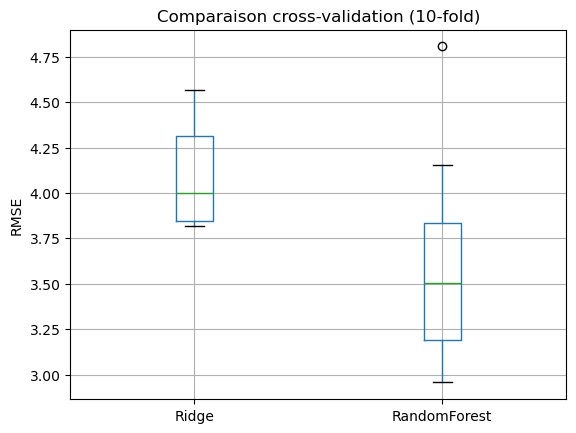

In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import numpy as np

# Pré-extraction des features une seule fois
X_features = feat_extractor.fit_transform(X_windows)

# Paramètres optimisés
cv_scores = {}
n_splits = min(10, len(np.unique(session_ids)))  # On limite à 10 plis max

for name, model in models.items():
    pipe = make_pipeline(
        StandardScaler(),
        model
    )
    
    # Utilisation de cross_validate pour plus de flexibilité
    cv_res = cross_validate(
        pipe,
        X_features,  # Utilisation des features pré-calculées
        y_windows,
        groups=session_ids,
        cv=n_splits,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        return_train_score=False,
        error_score='raise'
    )
    
    cv_scores[name] = -cv_res['test_score']  # Conversion en scores positifs

# Tableau des RMSE par pli
df_cv = pd.DataFrame(cv_scores)
display(df_cv)
print("RMSE moyen par modèle :")
print(df_cv.mean())

# Visualisation
df_cv.boxplot()
plt.ylabel("RMSE")
plt.title(f"Comparaison cross-validation ({n_splits}-fold)")
plt.show()

In [71]:
# 4. Feature importances

importances = {}
X_feat = feat_extractor.fit_transform(X_windows)
for name, model in models.items():
    pipe = Pipeline([('feat', feat_extractor), ('scaler', StandardScaler()), ('model', model)])
    pipe.fit(X_windows, y_windows)
    m = pipe.named_steps['model']
    if hasattr(m, 'coef_'):
        # Ridge multi-sortie : moyenne des |coefficients|
        importances[name] = np.mean(np.abs(m.coef_), axis=0)
    else:
        importances[name] = m.feature_importances_

df_imp = pd.DataFrame(importances, index=[f"f{i}" for i in range(X_feat.shape[1])])
display(df_imp.sort_values('RandomForest', ascending=False).head(20))  # top 10 RF
display(df_imp.sort_values('Ridge', ascending=False).head(20))         # top 10 Ridge


,Ridge,RandomForest
f34,1.953644,0.284978
f27,1.951391,0.246150
f13,3.327814,0.091376
f20,2.091570,0.065531
f7,2.887093,0.055956
f6,0.954096,0.038428
f48,2.182388,0.035749
f44,5.665251,0.032921
f21,2.773150,0.023611
f51,1.288254,0.016684


,Ridge,RandomForest
f43,5.701496,0.014471
f44,5.665251,0.032921
f28,4.200943,0.009311
f24,4.018722,0.000428
f9,3.335638,0.000513
f13,3.327814,0.091376
f50,3.152198,0.000577
f2,2.940125,0.002297
f49,2.913241,0.003079
f7,2.887093,0.055956


In [72]:
# 5. Sélection de features avec RFECV (optimisation du RMSE)

from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

def perform_feature_selection(models, feat_extractor, X_windows, y_windows, logo):
    """
    Effectue une sélection de features avec RFECV pour chaque modèle.
    
    Args:
        models (dict): Dictionnaire de modèles à évaluer
        feat_extractor: Transformateur pour l'extraction de features
        X_windows (pd.DataFrame): Features
        y_windows (pd.Series): Target
        logo: Stratégie de validation croisée Leave-One-Group-Out
    
    Returns:
        tuple: (selectors, optimal_counts, df_sel)
    """
    optimal_counts = {}
    selectors = {}

    for name, model in models.items():
        # Création du sélecteur RFECV
        sel = RFECV(
            estimator=model,
            cv=logo,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        # Pipeline complet
        pipe = Pipeline([
            ('feat', feat_extractor),
            ('scaler', StandardScaler()),
            ('select', sel),
            ('model', model)
        ])
        
        # Entraînement du pipeline
        pipe.fit(X_windows, y_windows)
        
        # Sauvegarde des résultats
        selectors[name] = sel
        optimal_counts[name] = sel.n_features_

    # Création du dataframe des résultats
    df_sel = pd.DataFrame.from_dict(
        optimal_counts, 
        orient='index', 
        columns=['n_features_opt']
    )
    
    return selectors, optimal_counts, df_sel

# Exemple d'utilisation
# selectors, optimal_counts, df_sel = perform_feature_selection(models, feat_extractor, X_windows, y_windows, logo)
# display(df_sel)

In [73]:
# 6. Pipeline final - Sélection et évaluation du meilleur modèle

def build_final_pipeline(models, cv_scores, selectors, optimal_counts, feat_extractor):
    """
    Construit et retourne le pipeline final avec le meilleur modèle sélectionné.
    
    Args:
        models (dict): Dictionnaire des modèles évalués
        cv_scores (dict): Scores de validation croisée pour chaque modèle
        selectors (dict): Sélecteurs RFECV pour chaque modèle
        optimal_counts (dict): Nombre optimal de features pour chaque modèle
        feat_extractor: Transformateur pour l'extraction de features
    
    Returns:
        tuple: (final_pipe, best_model_name, best_rmse, optimal_feature_count)
    """
    # Calcul du RMSE moyen pour chaque modèle
    mean_rmse = {model_name: scores.mean() for model_name, scores in cv_scores.items()}
    
    # Sélection du meilleur modèle (RMSE le plus bas)
    best_model_name = min(mean_rmse, key=mean_rmse.get)
    
    # Construction du pipeline final
    final_pipe = Pipeline([
        ('feat', feat_extractor),
        ('scaler', StandardScaler()),
        ('select', selectors[best_model_name]),
        ('model', models[best_model_name])
    ])
    
    # Affichage des résultats
    print(f"Modèle retenu : {best_model_name}")
    print(f"RMSE moyen (baseline) : {mean_rmse[best_model_name]:.3f}")
    print(f"Nombre optimal de features : {optimal_counts[best_model_name]}")
    
    return final_pipe, best_model_name, mean_rmse[best_model_name], optimal_counts[best_model_name]

# Exemple d'utilisation :
# final_pipe, best_model, best_rmse, optimal_feats = build_final_pipeline(
#     models, cv_scores, selectors, optimal_counts, feat_extractor
# )

 ## 5 ) Implementation of a regression model based on the covariance matrices pipeline  and a neural network approach using the PyTorch library

In [74]:
# Extract the first session dataset and put it to the (window, electrode, time) shape for features dataset and (window,target) shape for the target dataset.
X_0 =  X_guided_augmented[0].swapaxes(0, 1)
y_0 = Y_guided_slided[0].swapaxes(0, 1).reshape(len(X_0),51)
# Visualize shapes
print(" Guided first session features dataset shape:\n")
print(X_0.shape)
print(" Guided first session target dataset shape:\n")
print(y_0.shape)

 Guided first session features dataset shape:

(1837, 8, 500)
 Guided first session target dataset shape:

(1837, 51)


In [75]:
# Put the concatenated guided dataset to the (window, electrode, time) shape for features dataset and (window,target) shape for the target dataset.

X_guided=X_guided_augmented.swapaxes(1, 2)

NewX_guided=X_guided.reshape(X_guided.shape[0]*X_guided.shape[1],8,500)

Y_guided=Y_guided_slided.swapaxes(1, 2)

NewY_guided=Y_guided.reshape(Y_guided.shape[0]*Y_guided.shape[1],51)

# Visualize new shapes
print(" Guided features dataset shape:\n")
print(NewX_guided.shape)
print(" Guided target dataset shape:\n")
print(NewY_guided.shape)

 Guided features dataset shape:

(9185, 8, 500)
 Guided target dataset shape:

(9185, 51)


In [76]:
# Put the concatenated free moves dataset to the (window, electrode, time) shape for features dataset and (window,target) shape for the target dataset.

X_freemoves=X_freemoves_augmented.swapaxes(1, 2)

NewX_freemoves=X_freemoves.reshape(X_freemoves.shape[0]*X_freemoves.shape[1],8,500)

Y_freemoves=Y_freemoves_slided.swapaxes(1, 2)

NewY_freemoves=Y_freemoves.reshape(Y_freemoves.shape[0]*Y_freemoves.shape[1],51)
# Visualize new shapes
print(" Free moves features dataset shape:\n")
print(NewX_freemoves.shape)

print(" Free moves target dataset shape:\n")
print(NewY_freemoves.shape)


 Free moves features dataset shape:

(10785, 8, 500)
 Free moves target dataset shape:

(10785, 51)


### 2°) Implementation of a regression model based on the covariance matrices pipeline

#### a) Support Vector Regression (SVR)  models

The algorithm applied here is :

**Input** : Training dataset D, the kernel function type.

**Output**: models $h_{i} , i = 1,..., m$.

&nbsp;&nbsp;*Build m SVR Models*

1:&nbsp;&nbsp; **for i = 1 to m do**

&nbsp;&nbsp;&nbsp;&nbsp;*Create the CV training $D^{(k−j)}$ and test $D^{(j)}$ sets*
    
2: &nbsp;&nbsp;&nbsp;&nbsp;    **for j = 1 to k do**


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $D^{(k-j)} = \{(x^{k-j} , y_i^{k-j})\}$
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $D^{(j)}=\{(x^{j} , y{_i}^{j})\}$}
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Train the $j^{th}$ model on the training set $D^{(k−j)}$*
      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $h_{i}^{(k-j)} : D^{(k-j)} \Longrightarrow \mathbb{R}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Test the $j^{th}$ model on the test set $D^{(j)}$*
      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{Y_{i}} = h_{i}(X^{(j)})$

&nbsp;&nbsp;&nbsp;&nbsp;    **end for**

&nbsp;&nbsp;*Calculate CV RMSE error for the $i^{th}$ model*

&nbsp;&nbsp;*Select the $i^{th}$ best model based on the CV RMSE error by varying parameters*

&nbsp;&nbsp;*Store the $i^{th}$ best model and the associated RMSE error*

&nbsp;&nbsp;   **end for**

**return** $h_i, i = 1,..., m$


SVR models are built using a pipeline in the tangent space.

In [77]:
#Define the SVR best model function
def SVR_best_model(kernel,X,y):
    """
    This function performs the SVR models training and select the best models relying to the lowest RMSE. Input: X, y and kernel. Output: n=y.shape[1] best models.
    Inner parameters: C, gamma and degree in case of polynomial kernel.
    """
    #Define C and gamma values
    Gamma = ["scale","auto", 0.001, 0.1, 1,10]
    C = [1, 10, 100]
    #Initiliaze the KFold function
    kf = KFold(n_splits=5)
    #Initiliaze the best models and associated RMSE lists
    BestModels=[]
    RMSES=[]
    # Perform the CV. Loop on the number of targets
    for i in range (len(y[0])):
        # Bestmodel SVR pipeline and  associated RMSE initialization
        Bestmodel_RMSE=float('inf')
        BestModel=Pipeline([('cov', Covariances()),
                            ('ts',TangentSpace()),
                            ('svr', SVR())])
        # Select the ith target
        Y=y[:,i]
         # Loop on inner parameters C and gamma values
        for c in C:
            for gamma in Gamma:

                if kernel == 'poly':
                    # Loop on inner parameter degree values
                    for degree in [2,3,4,5,6,7]:
                       # Update the inner parameters in tangent space
                        clf_svr = Pipeline([
                            ('cov', Covariances()),
                            ('ts',TangentSpace()),
                            ('svr', SVR(gamma=gamma,C= c , kernel=kernel,degree=degree))

                            ]
                            )

                        RMSE_val=[]
                        NMSE_val=[]
                       # Split the dataset in CV train and validation sets. Train and valid models. Compute the cross-validation RMSE
                        for j, (train_index, val_index) in enumerate(kf.split(X,Y)):

                            x_train_per_fold, x_val_per_fold = X[train_index],X[val_index]
                            y_train_per_fold, y_val_per_fold = Y[train_index], Y[val_index]

                            clf_svr.fit(x_train_per_fold, y_train_per_fold)

                            val_predicts = clf_svr.predict(x_val_per_fold)

                            rmse_val=np.sqrt(np.mean((y_val_per_fold-val_predicts)**2))
                            RMSE_val.append(rmse_val)

                        # Select the best model for each target based on the RMSE
                        if np.mean(RMSE_val)>Bestmodel_RMSE:
                            continue

                        else:
                            BestModel=clf_svr
                            Bestmodel_RMSE=np.mean(RMSE_val)
                else:
                    # Perform CV for kernels other than polynomial kernel
                    # Update the inner parameters in tangent space
                    clf_svr = Pipeline([
                        ('cov', Covariances()),
                        ('ts',TangentSpace()),
                        ('svr', SVR(gamma=gamma,C= c, kernel=kernel))

                        ]
                        )


                    RMSE_val=[]
                 # Split the dataset in CV train and validation sets. Traine and valide models. Compute the CV RMSE
                    for j, (train_index, val_index) in enumerate(kf.split(X,Y)):

                        x_train_per_fold, x_val_per_fold = X[train_index],X[val_index]
                        y_train_per_fold, y_val_per_fold = Y[train_index], Y[val_index]

                        clf_svr.fit(x_train_per_fold, y_train_per_fold)

                        val_predicts = clf_svr.predict(x_val_per_fold)

                        rmse_val=np.sqrt(np.mean((y_val_per_fold-val_predicts)**2))
                        RMSE_val.append(rmse_val)
                 # Select the best model for each target based on the RMSE
                    if np.mean(RMSE_val)>Bestmodel_RMSE:
                        continue
                    else:
                        BestModel=clf_svr
                        Bestmodel_RMSE=np.mean(RMSE_val)
        BestModels.append(BestModel)
        RMSES.append(Bestmodel_RMSE)

    print("End of the process!")
    return BestModels,RMSES


In [78]:
# Define the predict function
def predict(bestmodels,Xtest):
    """
    This function performs multi-target predictions on features dataset. Input: list of best models and the features dataset.
    """
    predicts=[]
    # Loop on best models. Multi-target predictions
    for bestmodel in bestmodels:
        predicts.append(bestmodel.predict(Xtest))

    return predicts

In [79]:
#Define the SVR best model function
def RIDGE_best_model(X,y):

    #Initiliaze the KFold function
    kf = KFold(n_splits=5)
    #Initiliaze the best models and associated RMSE lists
    BestModels=[]
    RMSES=[]

    # Perform the CV. Loop on the number of targets
    for i in range (len(y[0])):
        # Bestmodel Ridge pipeline and  associated RMSE initialization
        Bestmodel_RMSE=float('inf')
        BestModel=Pipeline([
                          ('cov', Covariances()),
                          ('ts',TangentSpace()),
                          ('rr', Ridge())
                          ]
                          )
         # Select the ith target
        Y=y[:,i]
        # Loop on the inner parameters solver and alpha values
        for solver in ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']:
            for alpha in [0.1,0.5,1.0,5.0,10.0]:
                clf_rr = Pipeline([
                            ('cov', Covariances()),
                            ('ts',TangentSpace()),
                            ('svr', Ridge(solver=solver,alpha=alpha))

                            ]
                            )
                RMSE_val=[]
                # Split the dataset in CV train and validation sets. Train and valid models. Compute the cross-validation RMSE
                for j, (train_index, val_index) in enumerate(kf.split(X,Y)):
                    x_train_per_fold, x_val_per_fold = X[train_index],X[val_index]
                    y_train_per_fold, y_val_per_fold = Y[train_index], Y[val_index]

                    clf_rr.fit(x_train_per_fold, y_train_per_fold)

                    val_predicts = clf_rr.predict(x_val_per_fold)

                    rmse_val=np.sqrt(np.mean((y_val_per_fold-val_predicts)**2))
                    RMSE_val.append(rmse_val)
                 # Select the best model for each target based on the RMSE
                 # Update the inner parameters in tangent space
                if np.mean(RMSE_val)>Bestmodel_RMSE:
                    continue
                else:
                    BestModel=clf_rr
                    Bestmodel_RMSE=np.mean(RMSE_val)

        BestModels.append(BestModel)
        RMSES.append(Bestmodel_RMSE)

    print("End of the process!")
    return BestModels,RMSES

In [80]:
# Define the predict function
def predict(bestmodels,Xtest):
    predicts=[]
     # Loop on best models. Multi-target predictions
    for bestmodel in bestmodels:
        predicts.append(bestmodel.predict(Xtest))

    return predicts

# 6) Design and implement two ensembling strategies that combine the predictions of all individual regression models you implemented, each independently trained on distinct feature representations of the EMG signals.

A) Compute the average of the predicted values, such that the final prediction is given by

$$
\hat{y}_{\text{ensemble}} = \frac{1}{M} \sum_{m=1}^{M} \hat{y}_m
$$

where $\hat{y}_m$ denotes the prediction of the $m$-th model out of $M$ total models.
